# Speaker Identification With Deep Learning

## TODO: Demonstrate dataset download once we know the archive location

## Constructing our datasets

In [1]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt

import torchvision
from fastai import *
from fastai.data.all import *
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

The data is stored as wav files with a sample rate of 22050. The duration of wav files vary from 896 frames for the shortest and 37308 frames for the longest one.

For convenience, and to speed up training, let's load the data and zero pad the files to the duration of the longest recording.

In [2]:
anno = pd.read_csv('data/annotations.csv')

audio = []

for _, row in anno.iterrows():
    recording, _ = librosa.load(f'data/{row.split}/{row.filename}')
    example = np.zeros((37308))
    example[:recording.shape[0]] = recording
    audio.append(example)
    
anno['audio'] = audio

We now have the audio stored in our pandas dataframe as a column.

In [3]:
anno.head()

,class,split,filename,audio
0,TH,train,TH28.wav,"[0.005602472461760044, 0.005318541079759598, 0.003669876605272293, 0.0027520167641341686, 0.0009791548363864422, -0.00023344368673861027, -0.002091006375849247, -0.0034335379023104906, -0.005217831581830978, -0.00651963148266077, -0.008070231415331364, -0.00918870884925127, -0.010351252742111683, -0.011135116219520569, -0.011818679049611092, -0.012122733518481255, -0.01216581929475069, -0.011881929822266102, -0.01130811870098114, -0.010441402904689312, -0.009256338700652122, -0.007793310098350048, -0.006029308773577213, -0.004108010791242123, -0.0019488770049065351, 0.00031467314693145454,..."
1,TH,train,TH22.wav,"[0.008311716839671135, 0.009628401137888432, 0.009088602848351002, 0.009494212456047535, 0.008696266449987888, 0.008563422597944736, 0.007391049526631832, 0.006702062673866749, 0.005191943608224392, 0.004067244008183479, 0.002335942117497325, 0.0008737430325709283, -0.0010049340780824423, -0.002650944283232093, -0.004496815614402294, -0.006148578133434057, -0.007789283990859985, -0.009270048700273037, -0.010572473518550396, -0.011702651157975197, -0.012537986971437931, -0.013155621476471424, -0.013407011516392231, -0.01337549090385437, -0.012970197945833206, -0.012285810895264149, -0.01120..."
2,TH,train,TH928.wav,"[-0.005715873092412949, -0.006209362763911486, -0.005397230852395296, -0.005304799415171146, -0.004339906387031078, -0.0038921204395592213, -0.0027937060222029686, -0.002096844371408224, -0.000893308431841433, -4.8917387175606564e-05, 0.0011392176384106278, 0.0020308406092226505, 0.0030956179834902287, 0.003969485871493816, 0.004938427824527025, 0.005678411573171616, 0.0064082155004143715, 0.006949043367058039, 0.007307418622076511, 0.007578296586871147, 0.007662446703761816, 0.007644134573638439, 0.0074155922047793865, 0.00705992104485631, 0.006510879844427109, 0.005857332143932581, 0.005..."
3,TH,train,TH1145.wav,"[0.005164775066077709, 0.00611207215115428, 0.005967136938124895, 0.006382707506418228, 0.00601870147511363, 0.0060785384848713875, 0.005517073906958103, 0.005236890632659197, 0.004450420383363962, 0.003888575593009591, 0.0029293231200426817, 0.0021327855065464973, 0.0010679432889446616, 8.311581768793985e-05, -0.0010132426396012306, -0.002027825452387333, -0.0030795098282396793, -0.00403247494250536, -0.004920273553580046, -0.005769503768533468, -0.006489929277449846, -0.007085602264851332, -0.007500946056097746, -0.007792297285050154, -0.007849649526178837, -0.007784080225974321, -0.0075..."
4,TH,valid,TH470.wav,"[-0.005707798525691032, -0.005975733976811171, -0.004877748433500528, -0.004496271256357431, -0.0033175600692629814, -0.0026476725470274687, -0.001345088123343885, -0.000490039587020874, 0.0008650983218103647, 0.0018354931380599737, 0.003131938399747014, 0.004083011765033007, 0.005220739636570215, 0.0060868277214467525, 0.006983851548284292, 0.007628575898706913, 0.00818989984691143, 0.008543088100850582, 0.008714942261576653, 0.008739134296774864, 0.008489411324262619, 0.00808417983353138, 0.007457959931343794, 0.006665860302746296, 0.005642553325742483, 0.004491234198212624, 0.0031833327..."


Let's save the modified annotation file that now includes audio so that we can easily access it from other notebooks.

In [ ]:
anno.to_pickle('data/anno_with_audio.pkl')

We can listen to one of the examples to make sure everything worked.

In [4]:
Audio(anno.loc[0, 'audio'], rate=22050)

We could build a model straight on audio, possibly using [an RNN](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks) or [1d convolutions](https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n).

Instead, we will take a more traditional route. We will create spectrograms from audio and pass them into a [CNN model](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148), just like the ones used for image classification.

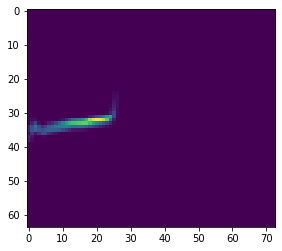

In [5]:
spec = librosa.feature.melspectrogram(
    anno.loc[0, 'audio'], fmin=200, fmax=800, n_mels=64
) # fmin and fmax taken from the paper
plt.imshow(spec);

We now have all the pieces of the puzzle in place. Let's put it all together to create datasets and dataloaders.

Dataloaders will read the examples, cast them to PyTorch tensors and put them on the GPU.

Since the fastai library doesn't natively support working with audio yet, let's construct our data pipelines manually.

This will also give us great control over the transformations we apply to our data.

For our `items` (examples in fastai parlance) we can use our `anno` dataframe. Each row will be treated as a single example. 

Let's define how we would like to go from a dataframe row to spectrogram first.

In [6]:
class Row2Specs(Transform):
    def encodes(self, row):
        spec = librosa.feature.melspectrogram(row.audio, fmin=200, fmax=800, n_mels=64)
        spec = np.tile(spec[:, :, None], 3) # adding channel dimension (64, 73, -> 3 <-) for use with vision models
        return spec.transpose(2,0,1) # PyTorch expects the 0th dimension to be channels

In [7]:
x_tfms = TfmdLists(anno, [Row2Specs])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


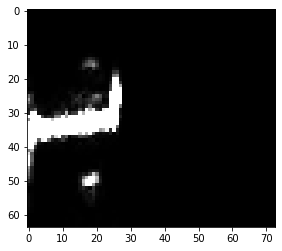

In [8]:
plt.imshow(x_tfms[0].transpose(1,2,0)) # displaying the first spectrogram in the dataset

We can also add simple per example normalization. This often helps models perform better on audio. 

In [9]:
class Normalize(Transform):
    def encodes(self, ary):
        return (ary - ary.mean()) / ary.std()

In [10]:
x_tfms = TfmdLists(anno, [Row2Specs, Normalize])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


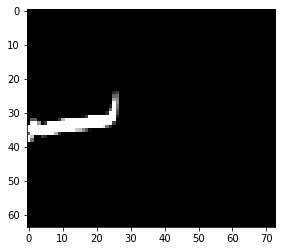

In [11]:
plt.imshow(x_tfms[0].transpose(1,2,0))

Now that we have the examples, it's time to work on the labels. How do we go from a dataframe row to a representation of class (speaker identity)?

Fastai provides the functionality that we need. All we have to do is provide instructions how to go from a row to the individual name.

In [12]:
anno['class'].unique()

array(['TH', 'BE', 'AL', 'MU', 'QU', 'SN', 'IO', 'TW'], dtype=object)

In [13]:
y_tfms = TfmdLists(anno, [lambda row: row['class'], Categorize])

In [14]:
y_tfms[0] # our class got represented in a way suitable for the model to understand!

TensorCategory(6)

Let's construct the datasets now.

In [15]:
# splitting data into the train and validation sets
splits = [
    np.where(anno.split == 'train')[0].tolist(),
    np.where(anno.split == 'valid')[0].tolist()
] 

dsets = Datasets(items=anno, tfms=[x_tfms, y_tfms], splits=splits)

In [16]:
len(dsets.train), len(dsets.valid)

(5828, 1457)

Let's now define moving the data onto the GPU. We will use a batch size of 32.

In [17]:
dls = dsets.dataloaders(bs=32)

And we are all set to train our model!

In [18]:
model = torchvision.models.resnet34(True)
model.fc = nn.Linear(512, 8) # converting the model to output the desired number of classes

In [19]:
learn = Learner(dls, model, CrossEntropyLossFlat(), metrics=[Precision(average='macro') ])

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0002290867705596611)

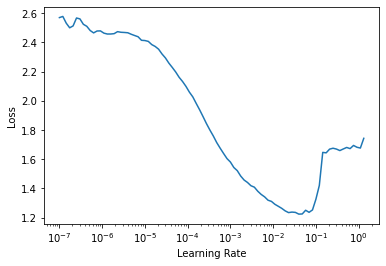

In [20]:
learn.lr_find() # using the lr finder to find an appropriate learning rate for our setup

In [21]:
learn.fit_one_cycle(10, lr_max=1e-3)

epoch,train_loss,valid_loss,precision_score,time
0,0.343477,0.370910,0.914620,00:12
1,0.336335,0.412944,0.876346,00:12
2,0.296845,0.606674,0.878534,00:12
3,0.243294,0.204205,0.945452,00:12
4,0.191264,0.197876,0.935621,00:12
5,0.158472,0.138215,0.949683,00:12
6,0.136423,0.126910,0.954695,00:12
7,0.089478,0.144643,0.953752,00:12
8,0.072506,0.118302,0.958057,00:12
9,0.058609,0.121668,0.958955,00:12


We achieve a mean average accuracy of 95% (vs 80% achieved in the paper using classical ML methods).

And which are the examples that our model gets wrong?

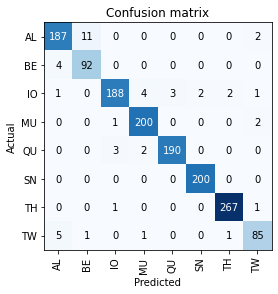

In [27]:
inter = ClassificationInterpretation.from_learner(learn)
inter.plot_confusion_matrix()

### Where to go next:

* umap + linear seperability of 2d projections with graphs
* demonstrate audio augmentations
* showcase cochlea architecture by Peter
* showcase representation toolkit by Peter
* demonstrate a 1d conv and RNN model
* polish the notebooks and move onto fruit bats
* ???